# CheMeleon, Chemprop, and ORCA Integration

----

**Disclaimer**  
This community notebook was kindly supplied by [Jackson Burns](https://github.com/JacksonBurns) for OPI version 1.0.0. It has been slightly adapted for working with the current OPI version.

----

With the release of [ORCA's Python interface](https://github.com/faccts/opi), it is now possible to directly integrate ORCA QM simulation results intro Chemprop models, all in code.

This notebook will demonstrate how to use the [CheMeleon pre-trained Chemprop model](https://doi.org/10.48550/arXiv.2506.15792) alongside ORCA to upgrade on-the-fly Hartree-Fock level HOMO-LUMO gap predictions up to the GW level of theory (a form of transfer learning).

Quick note on sources for this notebook, which may be helpful in extending it for your own work:
 - code for wrapping ORCA was derived from [this official ORCA tutorial](https://github.com/faccts/opi/blob/main/docs/contents/notebooks/ml_properties.ipynb)
 - Chemprop training code was derived from [the CheMeleon demo notebook](https://github.com/JacksonBurns/chemeleon/blob/main/finetuning_demo.ipynb) and [the RIGR demo notebook](https://github.com/chemprop/chemprop/blob/main/examples/rigr_featurizer.ipynb), which shows how to use featurizers
 - high-quality GW HOMO-LUMO gaps were retrieved from [this paper](https://www.nature.com/articles/s41597-023-02486-4) and manually collected using the [MoleculeNet `qm9.csv`](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv) to generate [`gwqm9.csv`](./gwqm9.csv)

This featurizer is best used from Python code, but you can add it to your local installation of Chemprop to make it accessible via the CLI.

## Step 1: Data Loading

First we'll load the training data for this study, which are HOMO-LUMO gaps calculated at the GW level of theory (very accurate).

In [ ]:
from pathlib import Path

import pandas as pd

In [ ]:
gwqm9_df = pd.read_csv(Path("data/gwqm9.csv"), index_col="gdb_id").sample(n=100, random_state=13)

In [3]:
gwqm9_df

,smiles,gap,homo,lumo
gdb_id,,,,
65846,CC1(OCC(=N)O1)C#C,11.944656,-10.941918,1.002738
50359,O=CC1CC2CCC2C1,11.160280,-10.254560,0.905720
9017,C#CC(=NCC#N)N,10.593476,-10.309429,0.284047
99106,CCC(=O)CC1(CC1)O,10.594400,-10.031040,0.563360
67617,CC12C3C4CN1C2C34O,10.072730,-9.144838,0.927892
...,...,...,...,...
68353,CC12CC(O1)C=CC=C2,8.874720,-8.965202,-0.090481
79727,OC1C2C(C3CN23)C1=O,10.044475,-9.890770,0.153705
42907,O=C1C(C2CN12)N1CC1,10.332981,-9.440558,0.892423


It's desirable to be able to predict the `gap` at the GW level of accuracy without actually expending the GW level of cost - this is where transfer learning comes in.
We will train a Chemprop-based model that takes HOMO and LUMO energy estimated using a cheap theory as inputs, and then outputs the predicted gap.
This improves model performance while using less total computational time relative to GW.

## Step 2: `featurizer` Setup

Next we need to set up the `featurizer`, which is Chemprop's way of translating a molecular structure, atom, or bond into a computer-readable vector.

Specifically here we are going to make a Molecule featurizer, which generates a feature vector that will be concatenated to the learned representation and then passed to the feedforward neural network.

We'll start by importing the corresponding ORCA and Chemprop classes.

In [4]:
import atexit
import json
import os
import shutil
from pathlib import Path

import numpy as np
from chemprop.featurizers import MoleculeFeaturizerRegistry, VectorFeaturizer
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from opi.core import Calculator
from opi.input.simple_keywords import BasisSet, Wft
from opi.input.structures.structure import Structure


This featurizer takes in the `working_directory` (where ORCA writes temporary files) and a set of keywords to configure how ORCA will behave.
When called, it then:
 - checks its cache to see if we have previously calculated this molecule, returning it if so
 - embeds the molecule using a quick RDKit-based force field calculation
 - calls ORCA via its Python interface
 - checks and prepares the results

Quick note about 2D vs. 3D.
Chemprop is an entirely 2D method, so incorporating 3D-based descriptors into the representation can improve its predictions of 3D properties (like those from QM simulations).
I appreciate the irony of the current "guess the geometry with a force field" approach, given that the geometries can actually be found in the original QM9 paper.
The point is that we might not have high-quality geometries in the future for new molecules we want to try predicting on, and that the neural network should be able to "pick up the slack" of using a cheap QM method combined with a cheap geometry guess.

In [ ]:
@MoleculeFeaturizerRegistry("orca_homo_lumo")
class ORCAHomoLumoFeaturizer(VectorFeaturizer[Chem.Mol]):
    h_to_eV = 27.2114

    def __init__(self, working_dir, simple_keywords_list):
        self.working_dir = working_dir
        self.simple_keywords_list = simple_keywords_list
        # caching - saves to memory during runs, saves to disk on exit (or manual call)
        self.cache = {}
        self.cache_file = "featurizer_cache.json"
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "r") as f:
                self.cache = json.load(f)
        atexit.register(self.dump_cache)
    
    def get_calculator(self):
        # clear output to avoid attempted restarts of previous calculations
        shutil.rmtree(self.working_dir, ignore_errors=True)
        self.working_dir.mkdir()
        # initialize the calculator and return it
        calculator = Calculator("single_point", self.working_dir)
        calculator.input.add_simple_keywords(*self.simple_keywords_list)
        calculator.input.ncores = 1
        return calculator

    def __len__(self) -> int:
        return 2  # HOMO and LUMO
    
    def _add_conf(mol: Chem.Mol):
        params = rdDistGeom.ETKDGv3()
        params.randomSeed = 0xf00d  # for reproducibility
        if AllChem.EmbedMolecule(mol, params) != 0:
            raise RuntimeError("Embedding failed")
        AllChem.UFFOptimizeMolecule(mol)

    def __call__(self, mol: Chem.Mol) -> np.ndarray:
        inchi = Chem.MolToInchi(mol)
        if inchi in self.cache:
            return np.array(self.cache[inchi], dtype=float)
        try:
            # embed 3d if absent
            if mol.GetNumConformers() == 0:
                ORCAHomoLumoFeaturizer._add_conf(mol)
            # setup and run calculation
            calculator = self.get_calculator()
            calculator.structure = Structure.from_rdkitmol(mol)
            calculator.write_input()
            calculator.run()
            # check for convergence
            output = calculator.get_output()
            if not output.terminated_normally():
                raise RuntimeError(f"Calculation for molecule {Chem.MolToSmiles(mol)} failed!")
            # get the results
            output.parse()
            HOMO_energy = output.get_homo().orbitalenergy * ORCAHomoLumoFeaturizer.h_to_eV
            LUMO_energy = output.get_lumo().orbitalenergy * ORCAHomoLumoFeaturizer.h_to_eV
            result = [HOMO_energy, LUMO_energy]
        except:  # if any stage of the calculation fails, just pass no information
            result = [0.0, 0.0]
        self.cache[inchi] = result
        return np.array(result)
    
    def dump_cache(self):
        with open(self.cache_file, "w") as f:
            json.dump(self.cache, f)

We'll define a directory for ORCA to store its temporary files:

In [6]:
working_dir = Path(".orca_outputs")

Then finally initialize the featurizer!
For this demo we will use a _very_ cheap QM method: Hartree-Fock with STO-3G orbitals.
We don't expect the absolute values of the HOMO-LUMO gaps to be accurate, but the _trend_ should be good enough that the neural network can improve it.

In [7]:
orca_feat = ORCAHomoLumoFeaturizer(
    working_dir,
    [
        Wft.HF,
        BasisSet.STO_3G,
    ]
)

We can test this featurizer on the first molecule in our dataset, just to see that it works:

In [8]:
output = orca_feat(Chem.AddHs(Chem.MolFromSmiles(gwqm9_df.iloc[0].loc["smiles"])))
output

[16:23:44] WARNING: Omitted undefined stereo



array([-8.41338135,  7.92808499])

## Step 3: Chemprop Training

Now we will get Chemprop set up, including:
 - `import`s for required classes
 - data preparation and casting to PyTorch-compatible types
 - downloading the CheMeleon pre-trained model
 - training and inference

In [9]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import numpy as np
from tqdm import tqdm
from rdkit.rdBase import BlockLogs
from chemprop import data, featurizers, models, nn
from chemprop.utils import make_mol

For the sake of this demo we will set a random seed for everything, making the results the same for everyone who runs the notebook.

In [10]:
pl.seed_everything(13)

Seed set to 13


13

Now we can use our `featurizer` to calculate the extra features for Chemprop!
Usage is very straightforward, all happening inside the list comprehension.

In [11]:
smis = gwqm9_df["smiles"].values
ys = gwqm9_df[["gap"]].values

mols = [make_mol(smi, add_h=True, keep_h=True) for smi in smis]

with BlockLogs():
    x_ds = [orca_feat(mol) for mol in tqdm(mols, desc="Running QM Simulations")]

all_data = [data.MoleculeDatapoint(mol, name=smi, y=y, x_d=x_d) for mol, smi, y, x_d in zip(mols, smis, ys, x_ds)]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

Running QM Simulations: 100%|██████████| 100/100 [00:00<00:00, 5410.61it/s]
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


We'll manually dump the cache to disk here - this will normally be called when your `python` exits, here we don't want to exit the notebook's kernel.

In [12]:
orca_feat.dump_cache()

Now we can finally cast everything into datasets and then start building the actual model.

In [13]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()
val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)
test_dset = data.MoleculeDataset(test_data[0], featurizer)
train_loader = data.build_dataloader(train_dset, num_workers=1)
val_loader = data.build_dataloader(val_dset, num_workers=1, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=1, shuffle=False)

To build the model, we first need to download the CheMeleon model weights from Zenodo.

In [14]:
from urllib.request import urlretrieve

In [15]:
ckpt_dir = Path().home() / ".chemprop"
ckpt_dir.mkdir(exist_ok=True)
mp_path = ckpt_dir / "chemeleon_mp.pt"
if not mp_path.exists():
    urlretrieve(
        r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
        mp_path,
    )

Now we can initialize the CheMeleon model with a new RegressionFFN for fine tuning on our task

In [16]:
import torch

In [17]:
agg = nn.MeanAggregation()
chemeleon_mp = torch.load(mp_path, weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])
agg = nn.MeanAggregation()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(
    input_dim=mp.output_dim + train_dset.d_xd,
    output_transform=output_transform,
)
batch_norm = False
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()] # Only the first metric is used for training and early stopping
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn



MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=2048, bias=False)
    (W_h): Linear(in_features=2048, out_features=2048, bias=False)
    (W_o): Linear(in_features=2120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2050, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weights=[[1.0]])
    (2): MSE(task_weights=[[1.0]])
  )
)

Finally, time for training and inference!

In [18]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    callbacks=[EarlyStopping("val_loss")],
    max_epochs=20, # number of epochs to train for
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(mpnn, train_loader, val_loader)

/home/jackson/miniconda3/envs/chemeleon_orca/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /home/jackson/chemeleon_orca/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/miniconda3/envs/chemeleon_orca/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 8.7 M  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | Identity           | 0      | train
3 | predictor       | RegressionFFN      | 6

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jackson/miniconda3/envs/chemeleon_orca/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [20]:
mpnn = models.MPNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [21]:
predictions = torch.cat([t.flatten() for t in trainer.predict(mpnn, test_loader)]).tolist()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jackson/miniconda3/envs/chemeleon_orca/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
initial_guess = [float(lumo - homo) for homo, lumo in np.array(x_ds)[test_indices][0]]

In [23]:
true_gap = test_dset.Y.flatten().tolist()

## Step 4: Visualizing Results

Using `matplotlib` we can compare how well the Force Field//Hartree-Fock+STO-3G HOMO-LUMO gaps and their CheMeleon-improved versions compare against the 'true' values from the GW dataset.
We've downsampled this dataset significantly for the purpose of a quick demo, but the same point still comes across!

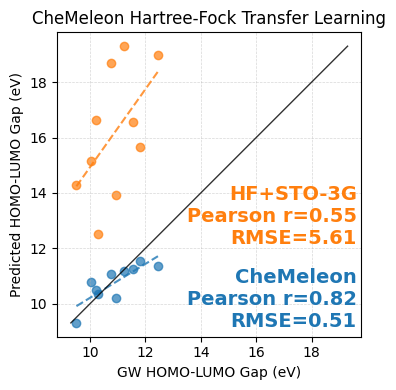

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

true_gap = np.array(true_gap)
initial_guess = np.array(initial_guess)
predictions = np.array(predictions)

rmse_init = np.sqrt(mean_squared_error(true_gap, initial_guess))
rmse_pred = np.sqrt(mean_squared_error(true_gap, predictions))
r_init, _ = pearsonr(true_gap, initial_guess)
r_pred, _ = pearsonr(true_gap, predictions)

def fit_and_plot(ax, x, y, color):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line, color=color, linestyle='--', alpha=0.8)
    ax.scatter(x, y, color=color, alpha=0.7)

fig, ax = plt.subplots(figsize=(4, 4))

fit_and_plot(ax, true_gap, initial_guess, 'tab:orange')
fit_and_plot(ax, true_gap, predictions, 'tab:blue')

# Parity line (y = x)
lims = [min(true_gap.min(), initial_guess.min(), predictions.min()),
        max(true_gap.max(), initial_guess.max(), predictions.max())]
ax.plot(lims, lims, 'k-', lw=1, alpha=0.8)

# Labels and style
ax.set_xlabel("GW HOMO-LUMO Gap (eV)")
ax.set_ylabel("Predicted HOMO-LUMO Gap (eV)")
ax.set_title("CheMeleon Hartree-Fock Transfer Learning")
ax.set_aspect('equal', 'box')

# Add stats text
ax.text(0.985, 0.5, f"HF+STO-3G\nPearson r={r_init:.2f}\nRMSE={rmse_init:.2f}",
        transform=ax.transAxes, ha='right', va='top', color='tab:orange',
        fontsize=14, fontweight='bold')

ax.text(0.985, 0.02, f"CheMeleon\nPearson r={r_pred:.2f}\nRMSE={rmse_pred:.2f}",
        transform=ax.transAxes, ha='right', va='bottom', color='tab:blue',
        fontsize=14, fontweight='bold')

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


CheMeleon corrects _both_ the linear offset from the parity line as well as the slope of the predictions, in doing so dramatically reducing the Root Mean Squared Error (RMSE).
While the resulting error isn't quite to the level of chemical accuracy, the dramatic improvement over the baseline show that, with more data (which we have) and some patience we could easily develop a strong model for this task.